In [1]:
import os
import itertools
from collections import Counter
from random import sample
from PIL import Image
from logging import WARNING
import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import random

## Загрузка данных

In [2]:
random.seed(0)

In [3]:
def load_all_data(path):
    food = []
    non_food = []
    for folder in tqdm.tqdm(os.listdir(path)):
        for filename in os.listdir(f'{path}/{folder}/food'):
            if random.random() < 0.8:
                food.append(Image.open(f'{path}/{folder}/food/{filename}'))
        for filename in os.listdir(f'{path}/{folder}/non_food'):
            if random.random() < 0.8:
                non_food.append(Image.open(f'{path}/{folder}/non_food/{filename}'))
    return food, non_food


food, non_food = load_all_data('data')

100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Конвертация в другое цветовое пространство

In [4]:
non_food = [(image if image.mode == 'RGB' else image.convert('RGB')) for image in non_food]

Приведение к одному размеру через добавление черных полос

In [5]:
def to_square(image: Image.Image, size=256):
    '''Функция для приведения изображения к квадрату заданого размера, с помощью добавления черных полос'''
    width, height = image.size
    if width == height:
        return image.resize((size, size))
    elif width > height:
        result = Image.new(image.mode, (width, width), (0, 0, 0))
        result.paste(image, (0, (width - height) // 2))
        return result.resize((size, size))
    else:
        result = Image.new(image.mode, (height, height), (0, 0, 0))
        result.paste(image, ((height - width) // 2, 0))
        return result.resize((size, size))


food_square = [to_square(image, size=100) for image in tqdm.tqdm(food)]
non_food_square = [to_square(image, size=100) for image in tqdm.tqdm(non_food)]

100%|██████████| 3997/3997 [01:41<00:00, 39.46it/s]


### Разделение на тестовую и тренировочную выборки

In [6]:
objects = np.array([np.array(image) for image in food_square + non_food_square]) #.transpose((2, 0, 1))
labels = np.array([1] * len(food_square) + [0] * len(non_food_square))

RATIO = (60, 20, 20) # train/test/valid
RATIO = [sum(RATIO[:i + 1]) for i in range(len(RATIO))]
length = len(labels)
all_index = np.array(range(length))
np.random.shuffle(all_index)
train_indexes = all_index[:length * RATIO[0] // 100]
test_indexes = all_index[length * RATIO[0] // 100:length * RATIO[1] // 100]
valid_indexes = all_index[length * RATIO[1] // 100:]

print('Размеры тренировочного, тестового, валидационного набора')
len(train_indexes), len(test_indexes), len(valid_indexes)
print(f'Форма объектов {objects.shape[1:]}')

Размеры тренировочного, тестового, валидационного набора
Форма объектов (100, 100, 3)


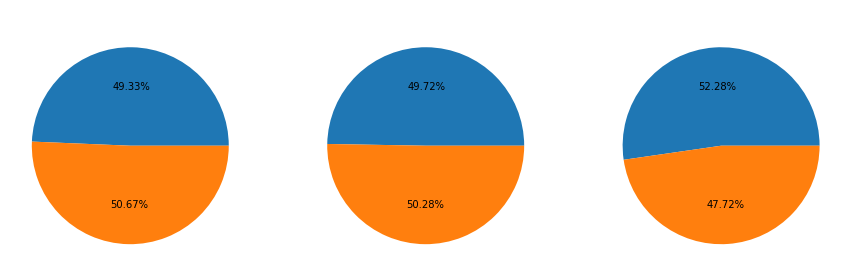

In [7]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
ax.pie(np.unique(labels[train_indexes], return_counts=True)[1], autopct='%.2f%%')
ax.set_title('Train', color='white')
ax = plt.subplot(1, 3, 2)
ax.pie(np.unique(labels[test_indexes], return_counts=True)[1], autopct='%.2f%%')
ax.set_title('Test', color='white')
ax = plt.subplot(1, 3, 3)
ax.pie(np.unique(labels[valid_indexes], return_counts=True)[1], autopct='%.2f%%')
ax.set_title('Valid', color='white')
plt.show()

Окончательное разделение

In [8]:
train_labels = labels[train_indexes]
train_images = objects[train_indexes]
valid_labels = labels[valid_indexes]
valid_images = objects[valid_indexes]
test_labels = labels[test_indexes]
test_images = objects[test_indexes]

In [9]:
model1 = tf.keras.Sequential(
    (tf.keras.layers.Conv2D(24, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'))
)
model2 = tf.keras.Sequential(
    (tf.keras.layers.Conv2D(24, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'))
)
model3 = tf.keras.Sequential(
    (tf.keras.layers.Conv2D(24, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(192, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'))
)

In [10]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [11]:
results1valid = []
results1train = []
results1test = []
results2valid = []
results2train = []
results2test = []
results3valid = []
results3train = []
results3test = []

Обучение

In [12]:
for i in range(15):
    print(f'Model 1 Epoch {i + 1}')
    model1.fit(train_images, train_labels, 64)
    results1valid.append(model1.evaluate(valid_images, valid_labels, 32)[1])
    results1test.append(model1.evaluate(test_images, test_labels, 32)[1])
    results1train.append(model1.evaluate(train_images, train_labels, 32)[1])
for i in range(15):
    print(f'Model 2 Epoch {i + 1}')
    model2.fit(train_images, train_labels, 64)
    results2valid.append(model2.evaluate(valid_images, valid_labels, 32)[1])
    results2test.append(model2.evaluate(test_images, test_labels, 32)[1])
    results2train.append(model2.evaluate(train_images, train_labels, 32)[1])
for i in range(15):
    print(f'Model 3 Epoch {i + 1}')
    model3.fit(train_images, train_labels, 64)
    results3valid.append(model3.evaluate(valid_images, valid_labels, 32)[1])
    results3test.append(model3.evaluate(test_images, test_labels, 32)[1])
    results3train.append(model3.evaluate(train_images, train_labels, 32)[1])

Model 1 Epoch 1
150/150 [==============================] - 11s 75ms/step - loss: 0.4596 - binary_accuracy: 0.8203
Model 1 Epoch 2
150/150 [==============================] - 11s 75ms/step - loss: 0.3229 - binary_accuracy: 0.8695
Model 1 Epoch 3
150/150 [==============================] - 11s 75ms/step - loss: 0.4463 - binary_accuracy: 0.8103
Model 1 Epoch 4
150/150 [==============================] - 11s 74ms/step - loss: 0.2370 - binary_accuracy: 0.9010
Model 1 Epoch 5
150/150 [==============================] - 11s 73ms/step - loss: 0.1536 - binary_accuracy: 0.9420
Model 1 Epoch 6
150/150 [==============================] - 12s 78ms/step - loss: 0.1274 - binary_accuracy: 0.9543
Model 1 Epoch 7
150/150 [==============================] - 11s 76ms/step - loss: 0.1035 - binary_accuracy: 0.9679
Model 1 Epoch 8
150/150 [==============================] - 12s 81ms/step - loss: 0.0808 - binary_accuracy: 0.9785
Model 1 Epoch 9
150/150 [==============================] - 12s 79ms/step - loss: 0.0645 

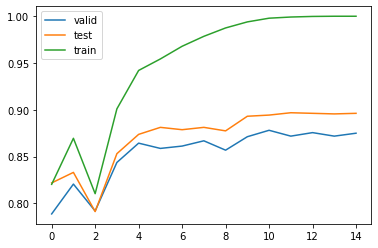

In [13]:
plt.plot(results1valid, label='valid')
plt.plot(results1test, label='test')
plt.plot(results1train, label='train')
plt.legend()

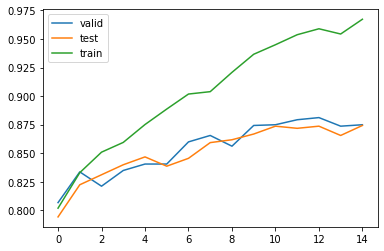

In [14]:
plt.plot(results2valid, label='valid')
plt.plot(results2test, label='test')
plt.plot(results2train, label='train')
plt.legend()

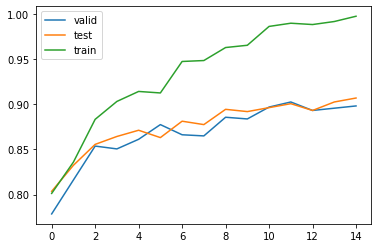

In [15]:
plt.plot(results3valid, label='valid')
plt.plot(results3test, label='test')
plt.plot(results3train, label='train')
plt.legend()